In [1]:
import joblib
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, roc_curve, ConfusionMatrixDisplay

In [2]:
#Modellabrufen
lr = joblib.load('LogReg-Model/logreg.pkl')
rf = joblib.load('Random_Forest/rf.pkl')
dt = joblib.load('Entscheidungsbaum/decision_tree.pkl')
knn = joblib.load('KNN-Model/knn.pkl')
models_dict = {"lr": lr, "rf": rf, "dt": dt, "knn": knn}

In [3]:
# Datenabrufen
X_train = pd.read_csv("../Resampling/X_train.csv", index_col=0)
X_test = pd.read_csv("../Resampling/X_test.csv", index_col=0)
X_val = pd.read_csv("../Resampling/X_val.csv", index_col=0)

X_train_stm = pd.read_csv("../Resampling/X_train_stm.csv", index_col=0)
X_test_stm = pd.read_csv("../Resampling/X_test_stm.csv", index_col=0)
X_val_stm = pd.read_csv("../Resampling/X_val_stm.csv", index_col=0)

y_train = pd.read_csv("../Resampling/y_train.csv", index_col=0)
y_train_stm = pd.read_csv("../Resampling/y_train_stm.csv", index_col=0)

y_test = pd.read_csv("../Resampling/y_test.csv", index_col=0)
y_val = pd.read_csv("../Resampling/y_val.csv", index_col=0)

print("Alle Datensätze wurden importiert.")

Alle Datensätze wurden importiert.


In [4]:
results = []

for name, mdl in tqdm(models_dict.items(), desc="Modelle evaluieren"):
    y_pred = mdl.predict(X_test)
    try:
        y_proba = mdl.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        auc = np.nan

    cm = confusion_matrix(y_test, y_pred)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": auc,

        "TN": cm[0,0], "FP": cm[0,1],
        "FN": cm[1,0], "TP": cm[1,1],
    })

df_results = pd.DataFrame(results).set_index("Model")
df_results = df_results.sort_values("F1-Score", ascending=False)
print(df_results)

Modelle evaluieren: 100%|██████████| 4/4 [19:27<00:00, 291.98s/it]

       Accuracy  Precision    Recall  F1-Score   ROC-AUC     TN     FP    FN  \
Model                                                                          
rf     0.802034   0.373286  0.619890  0.465972  0.824728  36310   7357  2687   
lr     0.723983   0.306382  0.776206  0.439347  0.819675  31245  12422  1582   
dt     0.780649   0.339576  0.607865  0.435735  0.800831  35310   8357  2772   
knn    0.677428   0.270637  0.775923  0.401302  0.788208  28885  14782  1584   

         TP  
Model        
rf     4382  
lr     5487  
dt     4297  
knn    5485  


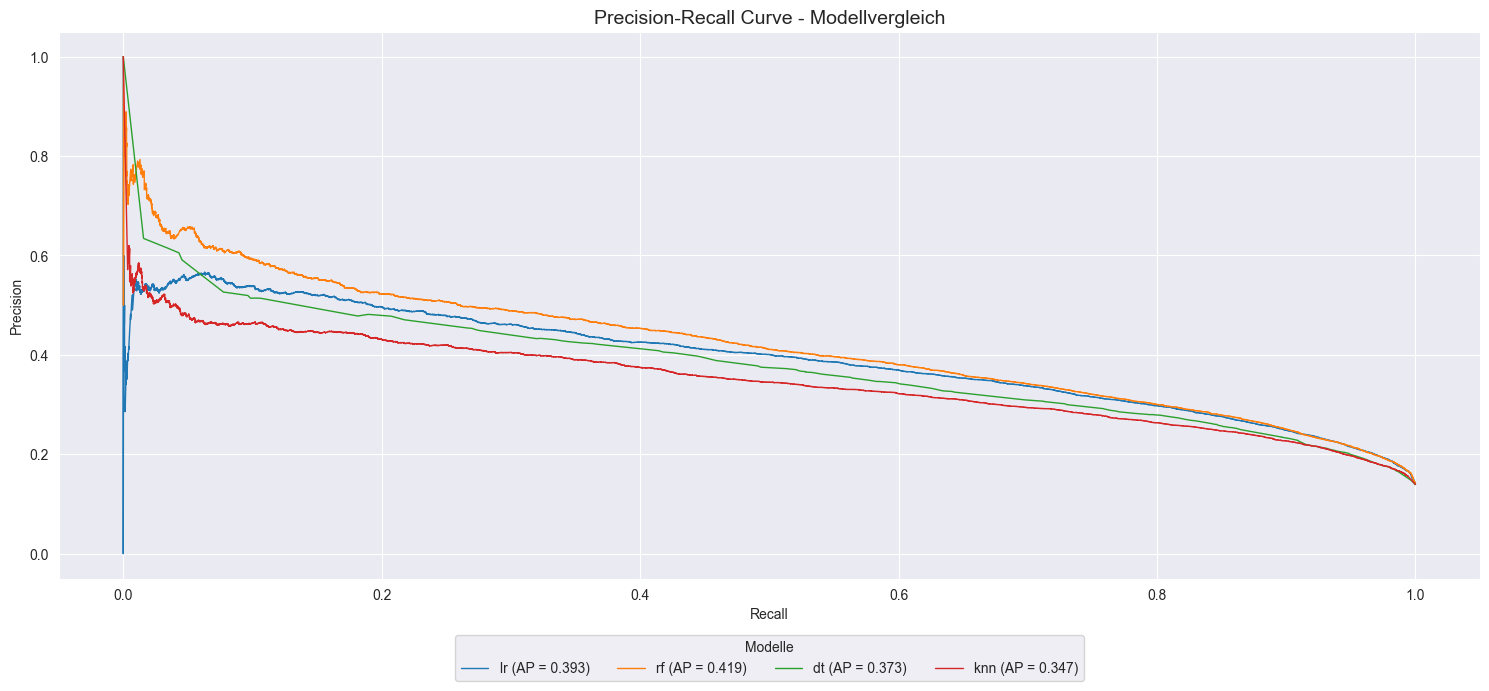

In [5]:
plt.figure(figsize=(15, 7))

for name, model in models_dict.items():
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        ap = average_precision_score(y_test, y_proba)
        plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})", linewidth=1)
    except Exception:
        continue

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Modellvergleich", fontsize=14)
plt.legend(title='Modelle', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=True)
plt.grid(True)
plt.tight_layout()

plt.savefig("prc.png",
            dpi=300,
            format="png",
            bbox_inches="tight",
            facecolor='w'
            )

plt.show()

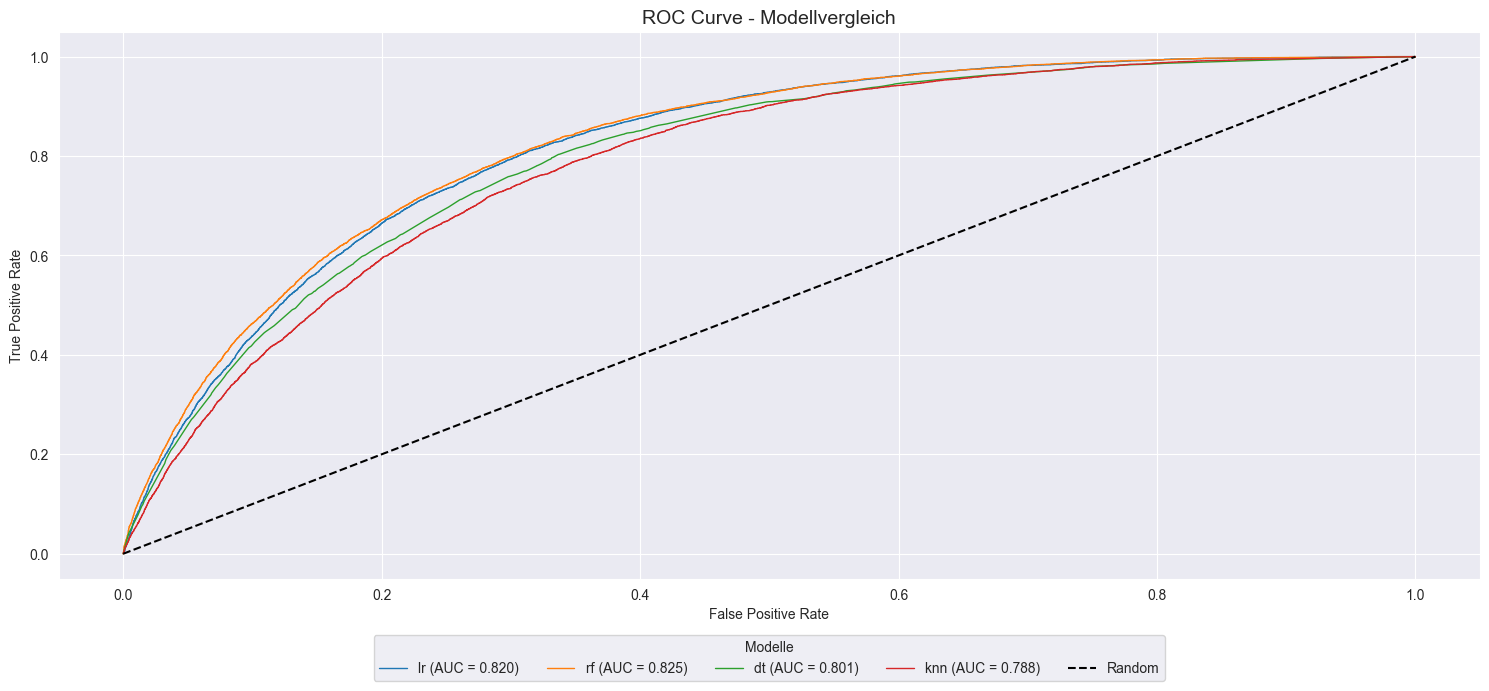

In [6]:
plt.figure(figsize=(15, 7))

for name, model in models_dict.items():
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", linewidth=1)
    except Exception as e:
        print(f"{name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Modellvergleich", fontsize=14)
plt.legend(title='Modelle', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, frameon=True)
plt.grid(True)
plt.tight_layout()

plt.savefig("auc.png",
            dpi=300,
            format="png",
            bbox_inches="tight",
            facecolor='w'
            )

plt.show()

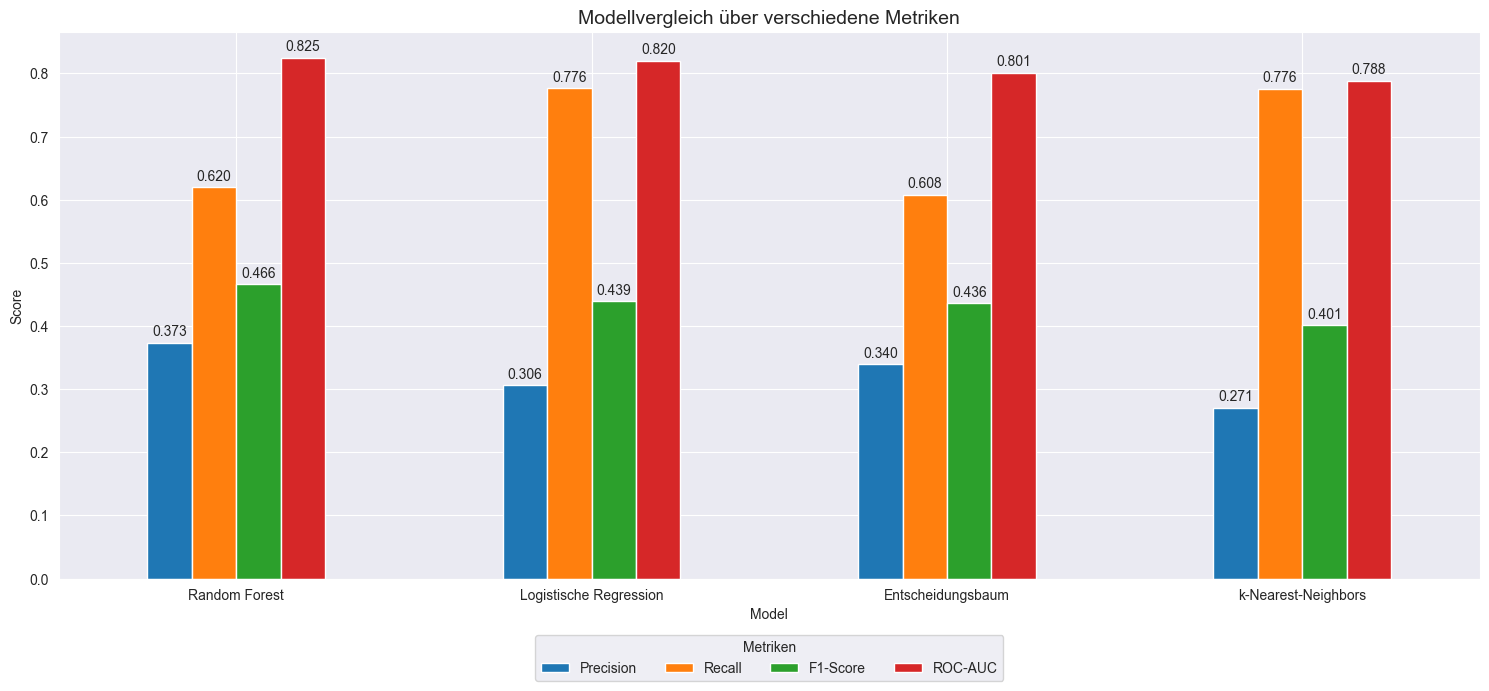

In [7]:
ax = df_results[["Precision", "Recall", "F1-Score", "ROC-AUC"]].plot.bar(
    figsize=(15, 7),
    rot=0
)

plt.title("Modellvergleich über verschiedene Metriken", fontsize=14)
plt.ylabel("Score")
plt.xticks(ticks=range(4), labels=['Random Forest', 'Logistische Regression', 'Entscheidungsbaum', 'k-Nearest-Neighbors'])
plt.grid(True, axis='y')
plt.legend(title='Metriken', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, frameon=True)

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if not pd.isna(height):
            ax.annotate(f"{height:.3f}",
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10)

plt.tight_layout()

plt.savefig("metrics.png",
            dpi=300,
            format="png",
            bbox_inches="tight",
            facecolor='w'
            )

plt.show()